In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#used to time things
import time
#apparently this is the best way to make a cartesian product, used for 
import itertools

In [2]:
fulldata = pd.read_excel('hr1mono_shuf000.xlsx')
data = fulldata.loc[fulldata['enc'] > (10**19.4 / 10**18), :].reset_index()
data

,index,enc,phi,zen,azi,sid,RA,DEC
0,140,49.9264,-119.82620,54.905788,209.82620,1.946264,4.797572,-9.854662
1,183,32.7601,10.63658,49.189766,79.36342,10.556682,219.543904,31.905075
2,246,37.2326,-105.18610,47.828472,195.18610,7.920878,107.545207,-6.491920
3,253,41.4675,-75.98251,32.753731,165.98251,7.286643,116.907081,8.153155
4,269,34.5096,166.31040,62.368916,283.68960,14.974571,148.888841,27.353289
...,...,...,...,...,...,...,...,...
127,10283,67.2994,-88.49757,31.712277,178.49757,15.121703,227.623990,8.490923
128,10327,28.2236,168.93320,60.521404,281.06680,18.384947,203.192811,26.438620
129,10365,46.5610,40.20316,41.986855,49.79684,5.479990,142.698905,54.053056
130,10402,54.2575,-145.59300,25.390541,235.59300,18.835975,259.857289,23.451771


In [3]:
def alt_azi_to_RA_DEC(phi, a, A, t):
    sinDEC = np.sin(a) * np.sin(phi) + np.cos(a) * np.cos(phi) * np.cos(A)
    DEC = np.arcsin(sinDEC)

    sinH = -1 * np.sin(A) * np.cos(a) / np.cos(DEC)
    cosH = (np.sin(a) - np.sin(DEC) * np.sin(phi)) / (np.cos(DEC) * np.cos(phi))

    #values might be slightly outside of [-1, 1], this will fix that
    sinH[sinH > 1] = 1
    sinH[sinH < -1] = -1
    cosH[cosH > 1] = 1
    cosH[cosH < -1] = -1

    #I don't trust the principle value of arcsin to always be the correct H,
    #so, this will double check with the cos(H) values
    H = np.empty(len(sinH))
    for i in range(len(sinH)):
        if abs(abs(np.arcsin(sinH[i])) - np.arccos(cosH[i])) < .001:
            H[i] = np.arcsin(sinH[i])
        else:
            H[i] = np.pi - np.arcsin(sinH[i])

    RA = np.mod(t * 15 - np.rad2deg(H), 360)
    return RA, np.rad2deg(DEC)

True
True


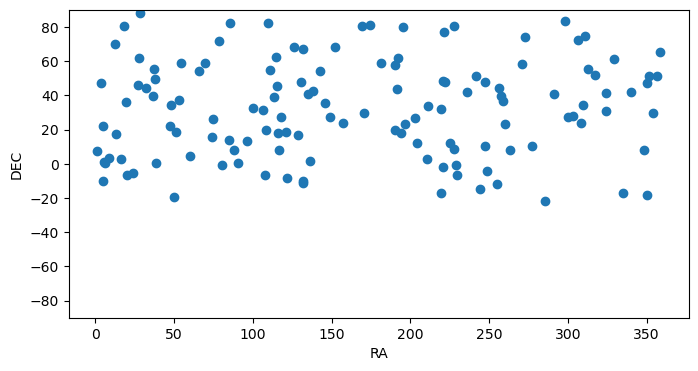

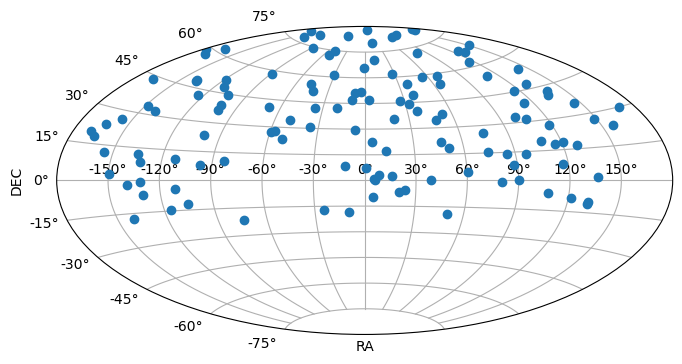

In [4]:
phi = np.deg2rad(40.195203)
a = np.deg2rad(90 - data['zen'])
A = np.deg2rad(data['azi'])
t = data['sid']

RA, DEC = alt_azi_to_RA_DEC(phi, a, A, t)

#this just check that I'm getting the right answers. True is good, False bad
print(all(abs(DEC - data['DEC']) < 0.001))
print(all(abs(RA - data['RA']) < 0.001))

#plots events as a scatter plot, both orthographic and aitoff
plt.figure(figsize = (8,4))
plt.plot(RA, DEC, 'o')
plt.ylim(-90,90)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

aitoffRA = np.copy(RA)
aitoffRA[aitoffRA >= 180] -= 360
plt.figure(figsize = (8,4))
plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.plot(np.deg2rad(aitoffRA), np.deg2rad(DEC), 'o')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

In [5]:
def RA_DEC_to_unit_vectors(RA, DEC):
    x = np.sin(np.deg2rad(90 - DEC)) * np.cos(np.deg2rad(-1 * RA))
    y = np.sin(np.deg2rad(90 - DEC)) * np.sin(np.deg2rad(-1 * RA))
    z = np.cos(np.deg2rad(90 - DEC))
    return np.array(np.array([x, y, z]).T)

def getparams():
    points = np.array(list(itertools.product(np.arange(360), np.arange(-90, 90))))

    X2 = RA_DEC_to_unit_vectors(points[:, 0], points[:, 1])
    
    theta = np.cos(np.deg2rad(20))
    return points, X2, theta

#23 seconds
def countsarray(localRA, localDEC, localpoints, localX2, localtheta):
    #start = time.time()
    localz = np.zeros((180, 360))
    X1 = RA_DEC_to_unit_vectors(localRA, localDEC)
    #print('time before loops: ', time.time() - start, ' sec')
    for x2 in range(localX2.shape[0]):
        for x1 in range(X1.shape[0]):
            if np.dot(X1[x1], localX2[x2]) > localtheta:
                localz[localpoints[x2, 1] + 90, localpoints[x2, 0]] += 1
    #print('time after loops: ', time.time() - start, ' sec')
    return localz


#plots a rectangular color plot
def colorplot(localz, title):
    plt.figure(figsize = (10,5))
    plt.imshow(localz, origin='lower', extent = [0, 360, -90, 90])
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.title(title)
    plt.colorbar()
    plt.show()

#plots a color plot with an aitoff projection
#I copied most of this online,
#https://stackoverflow.com/questions/49197997/project-numpy-array-to-aitoff-projection
#need to do something with the RA axis...
def aitoffcolorplot(localz, title):
    x = np.linspace(-np.pi,np.pi,localz.shape[1])
    y = np.linspace(-np.pi/2,np.pi/2,localz.shape[0])
    X,Y = np.meshgrid(x,y)
    
    plt.figure(figsize = (10,5))
    plt.subplot(111, projection="aitoff")
    plt.grid(True)
    plt.pcolormesh(X, Y[::-1], np.flip(np.roll(localz, 180, axis=1), axis = 0))
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.tick_params(axis='x', colors='white')
    plt.title(title)
    plt.colorbar()
    plt.show()

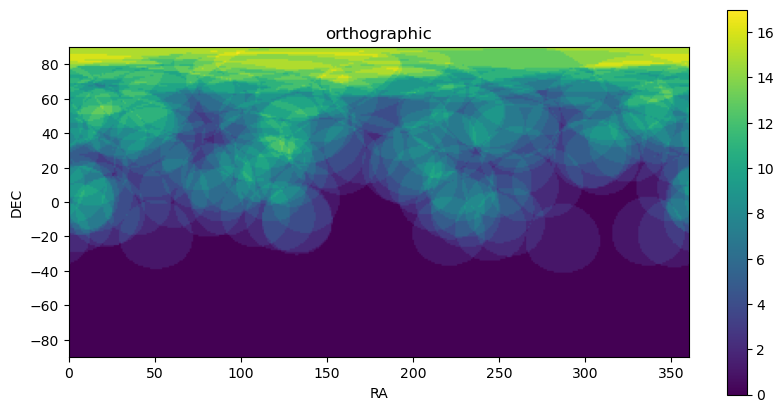

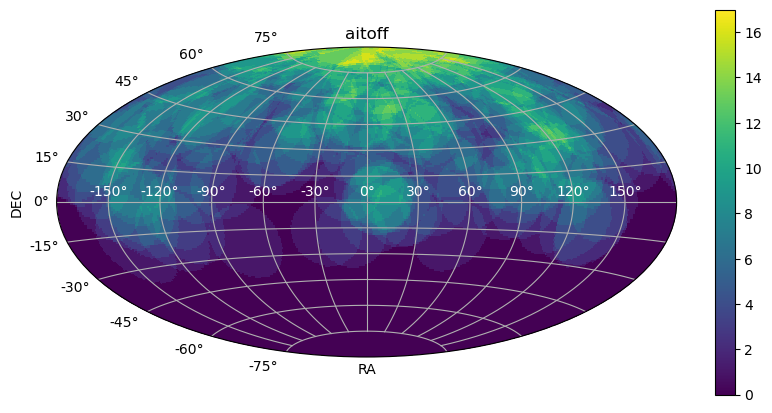

In [6]:
points, X2, theta = getparams()
z = countsarray(RA, DEC, points, X2, theta)
colorplot(z, 'orthographic')
aitoffcolorplot(z, 'aitoff')

In [ ]:
#loops a bunch of times, with shuffled sidereal times. 
#Each iteration is stored in a slice of Z
iterations = 1000
start = time.time()
Z = np.empty((180, 360, iterations))
points, X2, theta = getparams()

for i in range(iterations):
    t = np.random.permutation(data['sid'].values)
    RA, DEC = alt_azi_to_RA_DEC(phi, a, A, t)
    Z[:, :, i] = countsarray(RA, DEC, points, X2, theta)
    if np.mod(i + 1, 10) == 0:
        print(i, 'loops done')
print(iterations, 'loops took', (time.time() - start)/60, 'minutes')

In [ ]:
averageZ = np.mean(Z, axis = 2)
averagesquaredZ = np.mean(Z ** 2, axis = 2)
sigmaZ = np.sqrt(averagesquaredZ - averageZ ** 2)

In [ ]:
average = pd.DataFrame(averageZ)
averagesquared = pd.DataFrame(averagesquaredZ)
average.to_csv('averagebackup')
averagesquared.to_csv('averagesquaredbackup')